In [1]:
import numpy as np
import pandas as pd
import yaml
import torch
from copy import deepcopy
import matplotlib.pyplot as plt

from torch import nn
import scanpy as sc    

from celldreamer.data.scrnaseq_loader import RNAseqLoader
from celldreamer.models.featurizers.category_featurizer import CategoricalFeaturizer
from celldreamer.models.fm.denoising_model import SimpleMLPTimeStep
from celldreamer.models.fm.fm import FM
from celldreamer.eval.optimal_transport import wasserstein
import random
from celldreamer.models.base.utils import unsqueeze_right

device  = "cuda" if torch.cuda.is_available() else "cpu"

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


**Util function**

In [11]:
def init_feature_embeddings(dataset, dataset_config, device):
    feature_embeddings = {}  
    num_classes = {}
            
    for cov, cov_names in dataset.id2cov.items():
        feature_embeddings[cov] = CategoricalFeaturizer(len(cov_names), 
                                                                  dataset_config["one_hot_encode_features"], 
                                                                  device, 
                                                                  embedding_dimensions=dataset_config["cov_embedding_dimensions"])
        if dataset_config["one_hot_encode_features"]:
            num_classes[cov] = len(cov_names)
        else:
            num_classes[cov] = dataset_config["cov_embedding_dimensions"]
    return feature_embeddings

**Cofigurations**

In [12]:
ckpt = torch.load("/home/icb/alessandro.palma/environment/celldreamer/project_folder/experiments/fm_mlp_autoencoder_cond_dentate_small/61aaec8c-65dc-469d-8023-d9b6cc018e08/checkpoints/last.ckpt")

denoising_model = ckpt["hyper_parameters"]["denoising_model"]

In [13]:
print(ckpt["hyper_parameters"]["feature_embeddings"]["clusters"].embeddings.weight)
feature_embeddings = ckpt["hyper_parameters"]["feature_embeddings"]

Parameter containing:
tensor([[-1.8463,  0.4090, -0.4019,  ..., -0.0697,  1.1978, -0.5106],
        [ 0.6346, -0.8341, -0.9460,  ...,  1.0919,  0.9296,  1.2351],
        [ 0.9530,  2.1566, -1.4138,  ...,  0.8364, -0.3350,  0.0941],
        ...,
        [ 0.4447,  1.7756,  1.6217,  ..., -0.5001, -0.5452,  1.2627],
        [ 0.6627,  0.0387,  0.3179,  ...,  0.3266,  0.4493, -1.6064],
        [ 0.4141, -1.3991, -1.0783,  ..., -2.3223,  0.0235,  0.0025]],
       device='cuda:0', requires_grad=True)


In [14]:
dataset_config = {'dataset_path': '../../datasets/processed/dentategyrus.h5ad',
                    'layer_key': 'X_counts',
                    'covariate_keys': ['clusters'],
                    'sampling_covariate': 'clusters',
                    'subsample_frac': 1,
                    'encoder_type': 'learnt_autoencoder',
                    'target_max': 1,
                    'target_min': -1,
                    'n_dimensions': None,
                    'one_hot_encode_features': False,
                    'split_rates': [0.90, 0.05, 0.05],
                    'cov_embedding_dimensions': 100}

generative_model_config = {'x0_from_x_kwargs': {
                                'dims': [512, 256, 30],
                                'batch_norm': True,
                                'dropout': False,
                                'dropout_p': 0.0
                            },
                            'learning_rate': 0.0001,
                            'weight_decay': 0.00001,
                            'antithetic_time_sampling': True,
                            'scaling_method': 'log_normalization',
                            'pretrain_encoder': True,
                            'pretraining_encoder_epochs': 200,
                            'sigma': 0.5,
                            'covariate_specific_theta': False
                        }

**Initialization**

Initialize dataset 

In [15]:
data_path = dataset_config["dataset_path"]

dataset = RNAseqLoader(data_path=data_path,
                        layer_key=dataset_config["layer_key"],
                        covariate_keys=dataset_config["covariate_keys"],
                        subsample_frac=dataset_config["subsample_frac"], 
                        encoder_type=dataset_config["encoder_type"],
                        target_max=dataset_config["target_max"], 
                        target_min=dataset_config["target_min"])

in_dim = dataset.X.shape[1]
size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                                  "sd": dataset.log_size_factor_sd}

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [16]:
# feature_embeddings = init_feature_embeddings(dataset, dataset_config, device)

Initialize VDM 

In [17]:
generative_model = FM(
            denoising_model=denoising_model,
            feature_embeddings=feature_embeddings,
            plotting_folder=None,
            in_dim=in_dim,
            size_factor_statistics=size_factor_statistics,
            scaler=None,
            encoder_type=dataset_config["encoder_type"],
            model_type=denoising_model.model_type,
            conditioning_covariate="clusters",
            **generative_model_config  # model_kwargs should contain the rest of the arguments
        )

generative_model.load_state_dict(ckpt["state_dict"])
generative_model.to("cuda")

cacca


/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:198: Attribute 'denoising_model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['denoising_model'])`.


FM(
  (denoising_model): SimpleMLPTimeStep(
    (net): Sequential(
      (0): Linear(in_features=132, out_features=512, bias=True)
      (1): SELU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): SELU()
      (4): Linear(in_features=512, out_features=512, bias=True)
      (5): SELU()
      (6): Linear(in_features=512, out_features=30, bias=True)
    )
  )
  (criterion): MSELoss()
  (x0_from_x): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=2000, out_features=512, bias=True)
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (1): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
      (2): Linear(in_features=256, out_features=30, bias=True)
    )
  )
  (x_from_x0): MLP(
    (net): Seq

In [9]:
generative_model.feature_embeddings["clusters"].embeddings.weight

Parameter containing:
tensor([[-1.8463,  0.4090, -0.4019,  ..., -0.0697,  1.1978, -0.5106],
        [ 0.6346, -0.8341, -0.9460,  ...,  1.0919,  0.9296,  1.2351],
        [ 0.9530,  2.1566, -1.4138,  ...,  0.8364, -0.3350,  0.0941],
        ...,
        [ 0.4447,  1.7756,  1.6217,  ..., -0.5001, -0.5452,  1.2627],
        [ 0.6627,  0.0387,  0.3179,  ...,  0.3266,  0.4493, -1.6064],
        [ 0.4141, -1.3991, -1.0783,  ..., -2.3223,  0.0235,  0.0025]],
       device='cuda:0', requires_grad=True)

In [19]:
for param in generative_model.parameters():
    print(param)

Parameter containing:
tensor([4.3832, 5.8949, 4.3333,  ..., 6.0923, 4.9256, 5.6748], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([[-0.0557, -0.2992,  0.2161,  ..., -0.0438, -0.0460, -0.0327],
        [ 0.0542, -0.0592, -0.0106,  ..., -0.1524,  0.0656, -0.0419],
        [-0.0325,  0.1483,  0.0452,  ...,  0.0109,  0.1305,  0.0444],
        ...,
        [ 0.1350,  0.2071,  0.1310,  ..., -0.0350,  0.0296, -0.0570],
        [ 0.1228,  0.0359, -0.1120,  ..., -0.0008, -0.0310, -0.0609],
        [ 0.0420,  0.0334,  0.0668,  ..., -0.0885,  0.0448, -0.0508]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([-4.3356e-02, -1.6070e-03,  5.2008e-02, -5.9324e-02, -2.2528e-02,
        -4.9912e-02, -1.3364e-02, -1.2405e-02, -5.8218e-03, -6.5156e-02,
         3.4009e-02, -5.0465e-02,  3.4892e-02,  4.8893e-03,  1.9777e-03,
         1.5856e-02,  1.8152e-02, -3.7984e-03,  5.1178e-03, -5.7903e-02,
         4.5860e-02, -4.2068e-03, -1.3966e-02, -1.4522e-0

**Check the data**

In [10]:
adata_original = sc.read_h5ad(data_path)
adata_original.obs["size_factor"]=adata_original.X.A.sum(1)
X = torch.tensor(adata_original.layers["X_counts"].todense())

**Collect checkpoints and run**

General conditional

In [10]:
num_indices = 10000
index_range = len(X)

# Generate random dummy indices without replacement
indices = random.sample(range(index_range), num_indices)
adata_indices = adata_original[indices]

classes =  list(adata_indices.obs.clusters)
classes = torch.tensor([dataset.id2cov["clusters"][c] for  c in classes]).cuda()

log_size_factors = torch.log(torch.tensor(adata_indices.layers["X_counts"].sum(1))).cuda()

In [11]:
X_generated = generative_model.batched_sample(batch_size=100,
                                                repetitions=20,
                                                n_sample_steps=100, 
                                                covariate="clusters", 
                                                covariate_indices=classes, 
                                                log_size_factor=log_size_factors)

X_generated = X_generated.to("cpu")

Single condition

In [271]:
dataset.id2cov["clusters"]

{'CA': 0,
 'CA1-Sub': 1,
 'CA2-3-4': 2,
 'GlialProg': 3,
 'Granule': 4,
 'ImmAstro': 5,
 'ImmGranule1': 6,
 'ImmGranule2': 7,
 'Nbl1': 8,
 'Nbl2': 9,
 'OPC': 10,
 'RadialGlia': 11,
 'RadialGlia2': 12,
 'nIPC': 13}

In [324]:
# Pick condition 
condition_name = "ImmAstro"
condition_val = dataset.id2cov["clusters"][condition_name]
adata_cond = adata_original[adata_original.obs.clusters==condition_name]
n_to_generate = adata_cond.shape[0]

classes = condition_val*torch.ones(n_to_generate).long()

log_size_factors = torch.log(torch.tensor(adata_cond.layers["X_counts"].sum(1))).cuda()

In [325]:
X_generated = generative_model.sample(batch_size=n_to_generate,
                                        n_sample_steps=100, 
                                        covariate="clusters", 
                                        covariate_indices=classes, 
                                        log_size_factor=log_size_factors)

X_generated = X_generated.to("cpu")

**Create adata and check plots**

In [326]:
adata_generated = sc.AnnData(X=deepcopy(X_generated).cpu().numpy())

In [327]:
sc.pp.log1p(adata_generated)
sc.tl.pca(adata_generated)
sc.pp.neighbors(adata_generated)
sc.tl.umap(adata_generated)

In [328]:
adata_generated.obs["size_factor"] = adata_generated.X.sum(1)

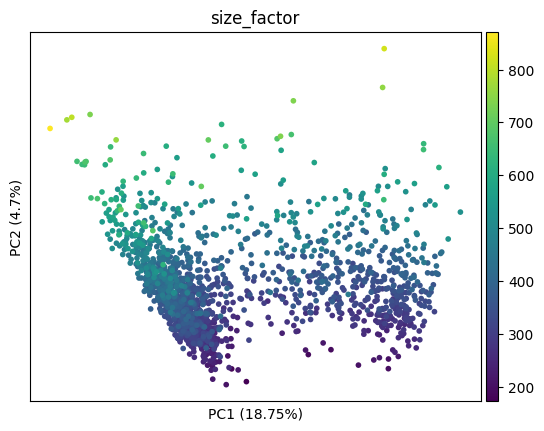

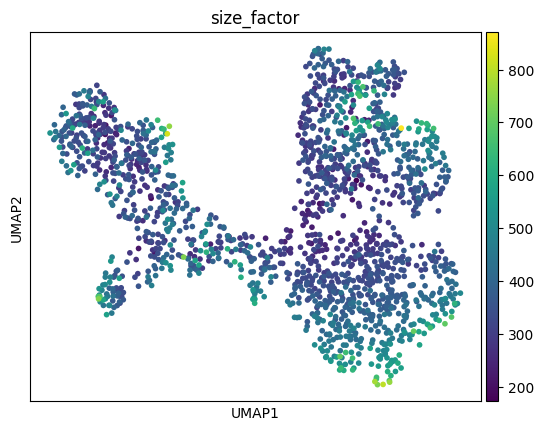

In [329]:
sc.pl.pca(adata_generated, color="size_factor", annotate_var_explained=True)
sc.pl.umap(adata_generated, color="size_factor")

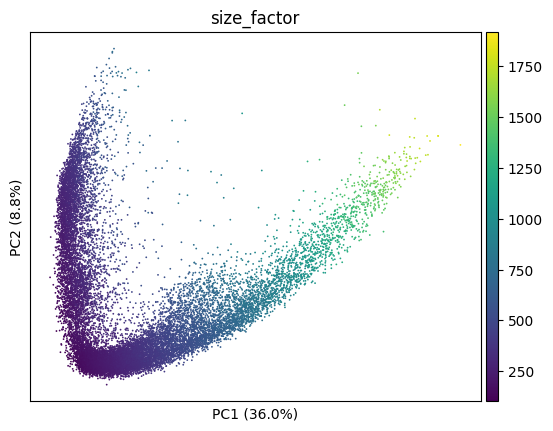

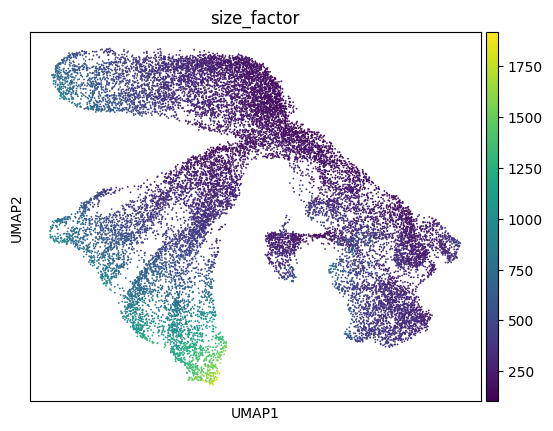

In [330]:
sc.pl.pca(adata_original, color="size_factor",  annotate_var_explained=True)
sc.pl.umap(adata_original, color="size_factor")

Merge and plot the generated and real data

In [331]:
dataset_type = ["Real" for _ in range(X.shape[0])] + ["Generated" for _ in range(X_generated.shape[0])]
dataset_type = pd.DataFrame(dataset_type)
dataset_type.columns = ["dataset_type"]

In [332]:
# If applicable 
cell_type = list(adata_original.obs.clusters) + [condition_name for _ in range(X_generated.shape[0])]
dataset_type["cell_type"] = cell_type

In [333]:
adata_merged = sc.AnnData(X=torch.cat([X, X_generated], dim=0).numpy(), 
                             obs=dataset_type)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [334]:
adata_original

AnnData object with n_obs × n_vars = 18213 × 2000
    obs: 'Age', 'clusters', 'size_factor'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'X_counts', 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [335]:
sc.pp.log1p(adata_merged) 
sc.tl.pca(adata_merged)
sc.pp.neighbors(adata_merged)
sc.tl.umap(adata_merged)

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


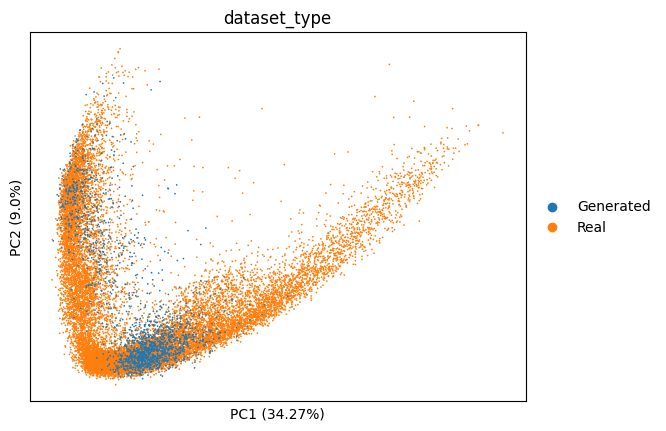

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoi

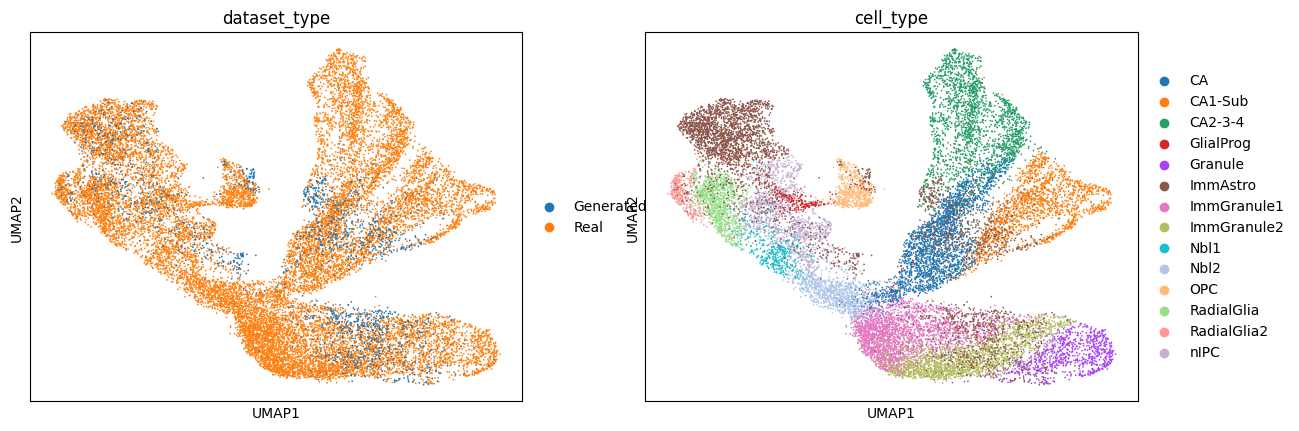

In [336]:
sc.pl.pca(adata_merged, color="dataset_type",  annotate_var_explained=True)
sc.pl.umap(adata_merged, color=["dataset_type", "cell_type"])

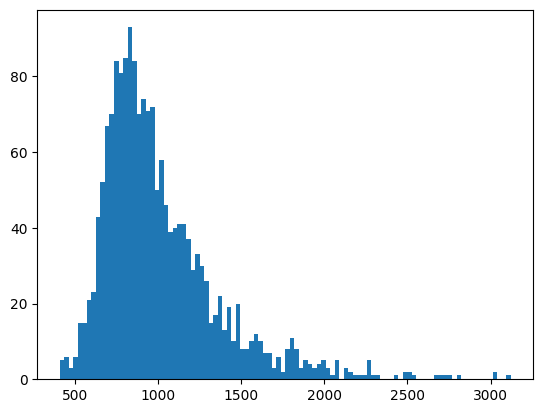

In [337]:
plt.hist(X_generated.sum(1), 100)
plt.show()

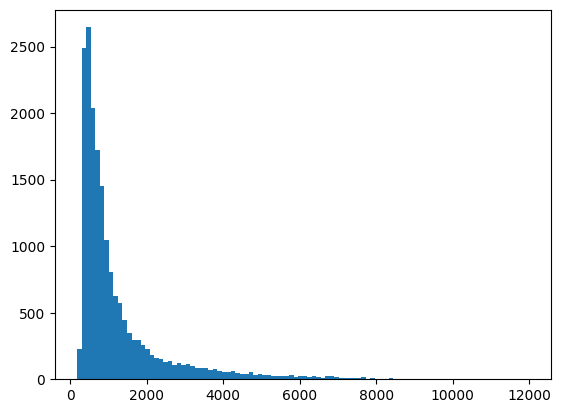

In [338]:
plt.hist(X.sum(1), 100)
plt.show()

In [339]:
(X_generated==0).sum(1).float().mean()

tensor(1660.4788)

In [340]:
(X==0).sum(1).float().mean()

tensor(1649.3105)

In [341]:
X.mean(1).mean()

tensor(0.6263)

In [342]:
X_generated.mean(1).mean()

tensor(0.5073)

**Check original data**

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


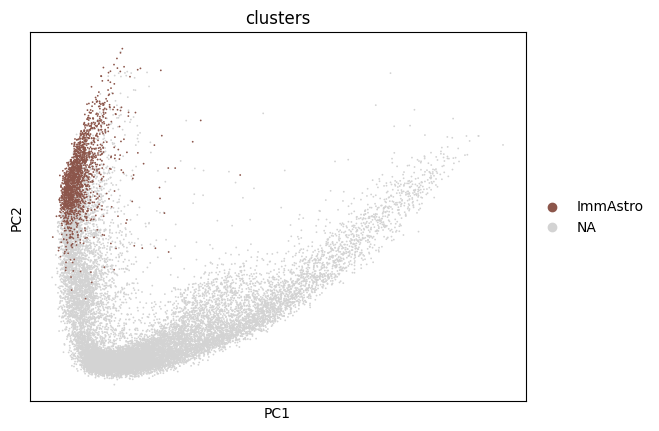

In [346]:
sc.pl.pca(adata_original, color="clusters", groups="ImmAstro")

/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/icb/alessandro.palma/miniconda3/envs/celldreamer/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


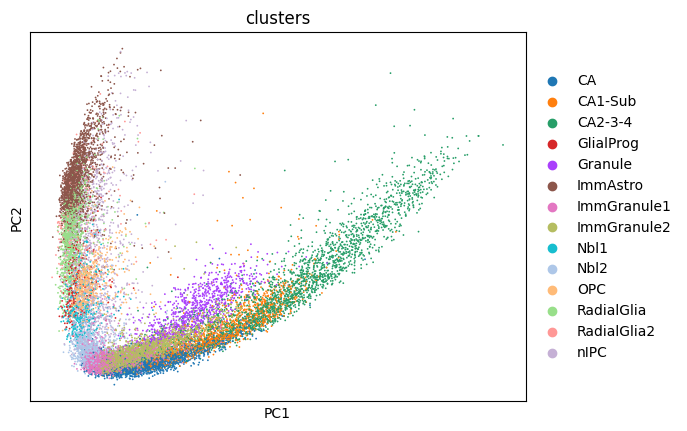

In [344]:
sc.pl.pca(adata_original, color="clusters")